In [ ]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from oasis.functions import deconvolve
from scipy.ndimage import binary_dilation, median_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import pearsonr
from tqdm import tqdm

from micromanager_gui.readers import TensorstoreZarrReader

In [2]:
R_SQUARE_THRESHOLD = 0.95

# path = "/Volumes/T7 Shield/neurons/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s.tensorstore.zarr"
# label_path = "/Volumes/T7 Shield/neurons/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s_labels"
path = "/Volumes/T7 Shield/neurons/NC240509_240523_Chronic/NC240509_240523_Chronic.tensorstore.zarr"
label_path = "/Volumes/T7 Shield/neurons/NC240509_240523_Chronic/NC240509_240523_Chronic_labels"

In [3]:
def single_exponential(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    return np.array(a * np.exp(-b * x) + c)


def get_exponential_decay(
    trace: np.ndarray,
) -> tuple[list[float], list[float], float] | None:
    """Fit an exponential decay to the trace.

    Returns None if the R squared value is less than 0.9.
    """
    time_points = np.arrange(len(trace))
    initial_guess = [max(trace), 0.01, min(trace)]
    try:
        popt, _ = curve_fit(
            single_exponential, time_points, trace, p0=initial_guess, maxfev=2000
        )
        fitted_curve = single_exponential(time_points, *popt)
        residuals = trace - fitted_curve
        r, _ = pearsonr(trace, fitted_curve)
        ss_total = np.sum((trace - np.mean(trace)) ** 2)
        ss_res = np.sum(residuals**2)
        r_squared = 1 - (ss_res / ss_total)
    except Exception as e:
        print("Error fitting curve: %s", e)
        return None

    return (
        None
        if r_squared <= R_SQUARE_THRESHOLD
        else (fitted_curve.tolist(), popt.tolist(), float(r_squared))
    )


def bi_exponential(
    x: np.ndarray, a1: float, b1: float, a2: float, b2: float, c: float
) -> np.ndarray:
    """Bi-exponential decay function."""
    return np.array(a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + c)


def get_bi_exponential_decay(
    trace: np.ndarray,
) -> tuple[list[float], list[float], float] | None:
    """Fit a bi-exponential decay to the trace.

    Returns None if the R squared value is less than 0.96.
    """
    time_points = np.arrange(len(trace))
    scaled_time = time_points / np.max(time_points)  # Normalize `x` to [0, 1]

    # Initial guess for the parameters: [a1, b1, a2, b2, c]
    initial_guess = [max(trace) / 2, 1.0, max(trace) / 2, 1.0, min(trace)]
    bounds = (
        [0, 0, 0, 0, -np.inf],
        [np.inf, 10, np.inf, 10, np.inf],
    )  # Parameter bounds

    try:
        popt, _ = curve_fit(
            bi_exponential,
            scaled_time,
            trace,
            p0=initial_guess,
            bounds=bounds,
            maxfev=5000,
        )
        fitted_curve = bi_exponential(scaled_time, *popt)
        residuals = trace - fitted_curve
        ss_total = np.sum((trace - np.mean(trace)) ** 2)
        ss_res = np.sum(residuals**2)
        r_squared = 1 - (ss_res / ss_total)
    except Exception as e:
        print(f"Error fitting bi-exponential curve: {e}")
        return None

    # Return None if the R² is less than R_SQUARE_THRESHOLD
    if r_squared <= R_SQUARE_THRESHOLD:
        return None

    return fitted_curve.tolist(), popt.tolist(), r_squared

def correct_photobleaching(trace: np.ndarray, fitted_curve: np.ndarray, offset: list[float]) -> np.ndarray:
    """Correct for photobleaching using the fitted curve."""
    # Subtract the fitted curve to remove photobleaching
    corrected_trace = trace - fitted_curve + offset

    # Normalize the corrected signal to maintain meaningful scaling
    corrected_trace = corrected_trace / np.mean(corrected_trace) * np.mean(trace)

    return corrected_trace

def calculate_dff(pc_trace, window=100, plot: bool = False):
    dff = []
    bg, median = _calculate_bg(pc_trace, window)
    bg = list(bg)
    dff = (pc_trace - bg) / bg
    dff = dff - np.min(dff)

    # plot median and background
    if plot:
        plt.figure(figsize=(10, 8))
        plt.plot(median, label="median", color="green")
        plt.plot(bg, label="background", color="black")
        plt.plot(pc_trace, label="trace", color="blue")
        plt.legend()
        plt.show()

    return dff


def _calculate_bg(f: np.ndarray, window: int):
    # Compute the median using a median filter
    rolling_median = median_filter(f, size=window, mode='nearest')

    # Calculate background using the lower quantile mean
    background = []
    for y in range(len(f)):
        x = max(0, y - window // 2)
        lower_quantile = f[x:y+1][f[x:y+1] <= rolling_median[y]]
        background.append(np.mean(lower_quantile) if len(lower_quantile) > 0 else f[y])

    return np.array(background), rolling_median


def _smooth_and_normalize(
    trace: np.ndarray, window_length: int = 5, polyorder: int = 2
) -> np.ndarray:
    """Smooth and normalize the trace between 0 and 1."""
    # smoothing that preserves the peaks
    smoothed = savgol_filter(trace, window_length=window_length, polyorder=polyorder)
    # normalize the smoothed trace from 0 to 1
    return (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))


def assign_left_bases(trace, peaks, left_bases):
    """Assign missing left_bases by finding the nearest local minimum to the left of the peak."""
    assigned_bases = []
    for peak in peaks:
        if peak in left_bases:
            assigned_bases.append(left_bases[list(left_bases).index(peak)])
        else:
            # Find the nearest local minimum to the left
            left_min = peak
            while left_min > 0 and trace[left_min - 1] <= trace[left_min]:
                left_min -= 1
            assigned_bases.append(left_min)
    return assigned_bases

In [298]:
ts = TensorstoreZarrReader(path)

In [339]:
POS = 205

data, meta = ts.isel(p=POS, metadata=True)
print(f"data shape: {data.shape}")

data shape: (350, 1024, 1024)

In [340]:
# GET THE LABELS IMAGE
event_key = "mda_event" if "mda_event" in meta[0] else "Event"
well = meta[0].get(event_key, {}).get("pos_name", f"pos_{str(POS).zfill(4)}")
labels_name = f"{well}_p{POS}.tif"
try:
    labels = tifffile.imread(f"{label_path}/{labels_name}")
except Exception as e:
    print(f"Error reading labels: {e}")

Both curves were fitted. The best curve was chosen: bi_exponential decay with R squared: 0.9990480144997596

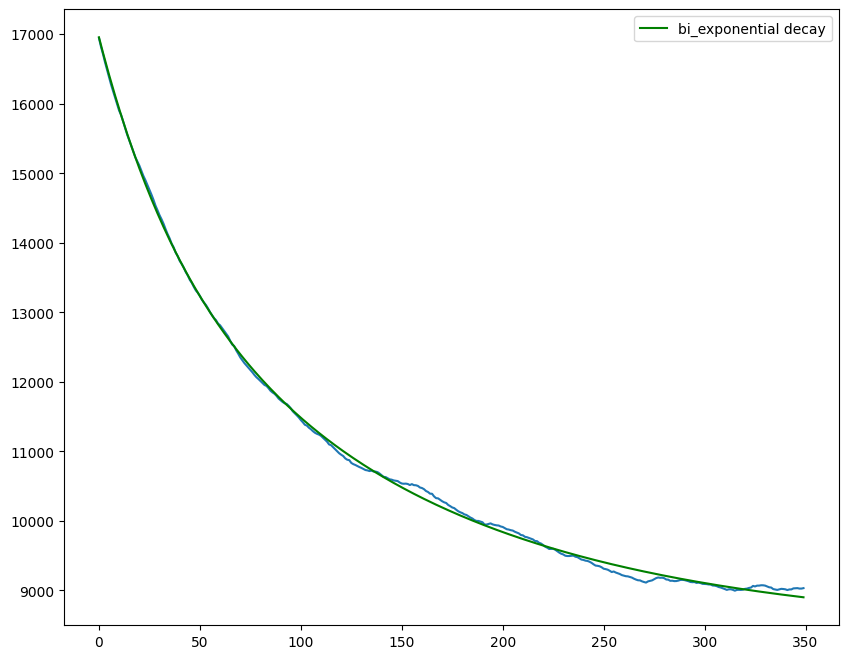

In [341]:
# CALCULATE AVERAGE (BI)EXPONENTIAL DECAY

average_trace = data.mean(axis=(1, 2))

r_squared_biexp = None
r_squared_exp = None

try:
    average_biexp_decay = get_bi_exponential_decay(average_trace)
    average_fitted_curve_biexp, average_popts_biexp, r_squared_biexp = (
        average_biexp_decay
    )
    ave_lbl = "bi_exponential decay"
except Exception as e:
    average_biexp_decay = None
    print(f"Error fitting bi-exponential curve: {e}")

try:
    average_exp_decay = get_exponential_decay(average_trace)
    average_fitted_curve_exp, average_popts_exp, r_squared_exp = average_exp_decay
    ave_lbl = "exponential decay"
except Exception as e:
    average_exp_decay = None
    print(f"Error fitting exponential curve: {e}")

if average_popts_biexp is None and average_popts_exp is None:
    average_fitted_curve = None
    average_popts = None
    average_r_squared = None
    average_offset = None
    msg = "No curve was fitted."

elif average_popts_biexp is None and average_popts_exp is not None:
    average_fitted_curve = average_fitted_curve_exp
    average_popts = average_popts_exp
    average_r_squared = r_squared_exp
    average_offset = average_popts[2]
    ave_lbl = "exponential decay"
    msg = f"Only exponential curve was fitted with R squared: {r_squared_exp}"

elif average_popts_biexp is not None and average_popts_exp is None:
    average_fitted_curve = average_fitted_curve_biexp
    average_popts = average_popts_biexp
    average_r_squared = r_squared_biexp
    average_offset = average_popts[4]
    ave_lbl = "bi_exponential decay"
    msg = f"Only bi-exponential curve was fitted with R squared: {r_squared_biexp}"

elif average_popts_biexp is not None and average_popts_exp is not None:
    if r_squared_biexp > r_squared_exp:
        average_fitted_curve = average_fitted_curve_biexp
        average_popts = average_popts_biexp
        average_r_squared = r_squared_biexp
        average_offset = average_popts[4]
        ave_lbl = "bi_exponential decay"
    else:
        average_fitted_curve = average_fitted_curve_exp
        average_popts = average_popts_exp
        average_r_squared = r_squared_exp
        average_offset = average_popts[2]
        ave_lbl = "exponential decay"
    msg = (
        f"Both curves were fitted. The best curve was chosen: {ave_lbl} "
        f"with R squared: {average_r_squared}"
    )

print(msg)

plt.figure(figsize=(10, 8))
plt.plot(average_trace)
plt.plot(average_fitted_curve, "green", label=ave_lbl)
plt.legend()
plt.show()

In [342]:
out_dir = Path("/Users/fdrgsp/Desktop/test") / f"pos{POS}"
out_dir.mkdir(exist_ok=True)

store_data = {}
all_dff = []
all_spikes_amplitudes = []

# CALCULATE (BI)EXPONENTIAL DECAY FOR EACH ROI. USE AVERAGE IF ROI FIT FAILS ----------

rois = np.max(labels)

for roi in tqdm(range(1, rois + 1)):

    store_data[roi] = {}

    mask = labels == roi
    masked_data = data[:, mask]

    roi_trace = masked_data.mean(axis=1)

    store_data[roi]["roi_trace"] = roi_trace

    r_squared_biexp = None
    r_squared_exp = None

    try:
        biexp_decay = get_bi_exponential_decay(roi_trace)
        fitted_curve_biexp, popts_biexp, r_squared_biexp = biexp_decay
    except Exception:
        biexp_decay = None
        # print(f"Error fitting bi-exponential curve: {e}")

    try:
        exp_decay = get_exponential_decay(roi_trace)
        fitted_curve_exp, popts_exp, r_squared_exp = exp_decay
    except Exception:
        exp_decay = None
        # print(f"Error fitting exponential curve: {e}")

    if biexp_decay is None and exp_decay is None:
        if average_fitted_curve is None:
            raise ValueError("No curve was fitted.")

        fitted_curve = average_fitted_curve
        popts = average_popts
        r_squared = average_r_squared
        offset = average_offset
        lbl = "using average curve"

    elif biexp_decay is not None and exp_decay is None:
        fitted_curve = fitted_curve_biexp
        popts = popts_biexp
        r_squared = r_squared_biexp
        offset = popts[4]
        lbl = "using bi_exponential decay"

    elif biexp_decay is None and exp_decay is not None:
        fitted_curve = fitted_curve_exp
        popts = popts_exp
        r_squared = r_squared_exp
        offset = popts[2]
        lbl = "using exponential decay"

    elif biexp_decay is not None and exp_decay is not None:
        if r_squared_biexp > r_squared_exp:
            fitted_curve = fitted_curve_biexp
            popts = popts_biexp
            r_squared = r_squared_biexp
            offset = popts[4]
            lbl = "using bi_exponential decay"
        else:
            fitted_curve = fitted_curve_exp
            popts = popts_exp
            r_squared = r_squared_exp
            offset = popts[2]
            lbl = "using exponential decay"

    # CORRECT PHOTOBLEACHING USING FITTED CURVE ------------------------------

    bleach_corrected = correct_photobleaching(roi_trace, fitted_curve, offset)
    store_data[roi]["bleach_corrected"] = bleach_corrected

    # CALCULATE DELATA F OVER F ----------------------------------------------

    dff = calculate_dff(bleach_corrected, window=50, plot=False)

    all_dff.extend(dff)
    store_data[roi]["dff"] = dff

    # normalize dff between 0 and 1
    # dff = (dff - np.min(dff)) / (np.max(dff) - np.min(dff))

    # DECONVOLVE DFF --------------------------------------------------------

    dec_dff, pk, _, k, _ = deconvolve(dff, penalty=1)
    # dec_dff, pk, _, k, _ = deconvolve(dff, g=(None, None), penalty=1)
    # dec_dff, pk, _, k, _ = deconvolve(dff, g=(0.95,), penalty=1)
    # dec_dff, pk, _, k, _ = deconvolve(dff, g=(1.2, -0.3), penalty=1)
    store_data[roi]["dec_dff"] = dec_dff
    store_data[roi]["pk"] = pk

    # FIND PEAKS ------------------------------------------------------------

    # normalize pk between 0 and 1
    # pk = (pk - np.min(pk)) / (np.max(pk) - np.min(pk))

    prominence_dff = np.mean(dff) * 0.1 # 20% of the mean of the dff
    pks_dff, _ = find_peaks(dff, prominence=prominence_dff)
    pks_spikes, _ = find_peaks(pk)
    store_data[roi]["pks_dff"] = pks_dff
    store_data[roi]["pks_spikes"] = pks_spikes

    # Get the amplitudes of the spikes
    spikes_amplitudes = pk[pks_dff]
    store_data[roi]["spikes_amp"] = spikes_amplitudes
    all_spikes_amplitudes.extend(spikes_amplitudes)


100%|██████████| 151/151 [00:05<00:00, 26.59it/s]


In [343]:
max_val_dff = np.max(all_dff)
max_val_spikes_amp = np.max(all_spikes_amplitudes)

# Normalize dff values specifically for detected peaks
norm_dff_color = Normalize(vmin=0, vmax=max_val_dff * 0.3)
norm_pk_color = Normalize(vmin=0, vmax= max_val_spikes_amp * 0.5)

# stack max projection
half = len(data) // 2
img = np.max(data[half:], axis=0)
img_normalized = (img / img.max() * 255).astype(np.uint8)
img_color = np.stack([img_normalized] * 3, axis=-1)

# make the composite plots
for r in tqdm(range(1, rois + 1)):

    # retrieve the data for the current ROI
    rt = store_data[r]["roi_trace"]
    bc = store_data[r]["bleach_corrected"]
    spikes_amp = store_data[r]["spikes_amp"]
    dff = store_data[r]["dff"]
    pk = store_data[r]["pk"]
    pks_dff = store_data[r]["pks_dff"]
    pks_spikes = store_data[r]["pks_spikes"]

    # Composite plot with all subplots for the current ROI
    fig = plt.figure(figsize=(20, 25))
    fig.suptitle(f"Composite Plot for ROI {r}", fontsize=16)

    # Define a grid with 2 rows and 2 columns
    gs = GridSpec(4, 2, figure=fig)

    # draw the roi mask edges on the image
    mask = labels == r
    # find the edges of the mask by dilating it and subtracting the original mask
    edges = binary_dilation(mask, iterations=5) & ~mask
    img_color_r = img_color.copy()
    img_color_r[edges] = [0, 255, 0]  # RGB for green

    # Subplot 0: ROI Mask Contour
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img_color_r, cmap="gray")
    ax0.set_title("ROI Mask")
    ax0.axis("off")

    # Subplot 1: Corrected trace
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(rt, label="original", color="magenta")
    ax1.plot(bc, label="corrected", color="green")
    ax1.set_title("Corrected Trace")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Fluorescence Intensity")
    ax1.legend()

    # Subplot 2: dF/F and Peaks
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(dff, label="dff", color="magenta")
    ax2.plot(pks_dff, dff[pks_dff], "kx", label="peaks dff")
    ax2.set_xlim(0, len(dff))
    ax2.set_title("Deconvolved DFF and Peaks")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Fluorescence Intensity (dF/F)")
    ax2.legend()

    # Subplot 3: Spikes and Peaks
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(pk, color="green")
    ax3.plot(pk, label="spikes", color="green")
    ax3.plot(pks_spikes, pk[pks_spikes], "kx", label="peaks spikes")
    ax3.set_title("Spikes and Peaks")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Fluorescence Intensity (dF/F)")
    ax3.set_xlim(0, len(pk))
    ax3.legend()

    # Subplot 4: dF/F and Peaks (at scale)
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(dff, label="dff", color="magenta")
    ax4.plot(pks_dff, dff[pks_dff], "kx", label="peaks dff")
    ax4.set_title("Deconvolved DFF and Peaks (at scale)")
    ax4.set_xlabel("Time")
    ax4.set_ylabel("Fluorescence Intensity (dF/F)")
    ax4.set_ylim(0, max_val_dff)
    ax4.set_xlim(0, len(dff))
    ax4.legend()

    # Subplot 5: Spikes and Peaks (at scale)
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(pk, color="green")
    ax5.plot(pk, label="spikes", color="green")
    ax5.plot(pks_spikes, pk[pks_spikes], "kx", label="peaks spikes")
    ax5.set_title("Spikes and Peaks (at scale)")
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Fluorescence Intensity (dF/F)")
    ax5.set_ylim(0, max_val_dff)
    ax5.set_xlim(0, len(pk))
    ax5.legend()

    # Subplot 5: Raster plot for dF/F
    ax6 = fig.add_subplot(gs[3, 0])
    for p in pks_dff:
        peak_intensity = dff[p]  # Get the actual intensity value at this peak
        peak_color = cm.viridis(norm_dff_color(peak_intensity))
        ax6.axvspan(
            p - 0.5,
            p + 0.5,
            ymin=0,
            ymax=1,
            color=peak_color,
        )
    ax6.set_title("Raster Plot dF/F")
    ax6.get_yaxis().set_visible(False)
    ax6.set_xlabel("Time")
    ax6.set_xlim(0, len(dff))

    # Subplot 7: Raster plot for spikes
    ax7 = fig.add_subplot(gs[3, 1])
    for px in pks_spikes:
        # Map the spike intensity at each peak to its corresponding color
        spike_intensity = pk[px]  # Get the actual intensity value at this spike
        spike_color = cm.viridis(norm_pk_color(spike_intensity))
        ax7.axvspan(
            px - 0.5,
            px + 0.5,
            ymin=0,
            ymax=1,
            color=spike_color,
        )
    ax7.set_title("Raster Plot Spikes")
    ax7.set_xlabel("Time")
    ax7.get_yaxis().set_visible(False)
    ax7.set_xlim(0, len(pk))

    plt.tight_layout()

    # Save the composite figure
    composite_plot_path = out_dir / f"composite_roi_{r}.png"
    plt.savefig(composite_plot_path)
    plt.close()

100%|██████████| 151/151 [02:47<00:00,  1.11s/it]


100%|██████████| 151/151 [00:01<00:00, 78.79it/s]


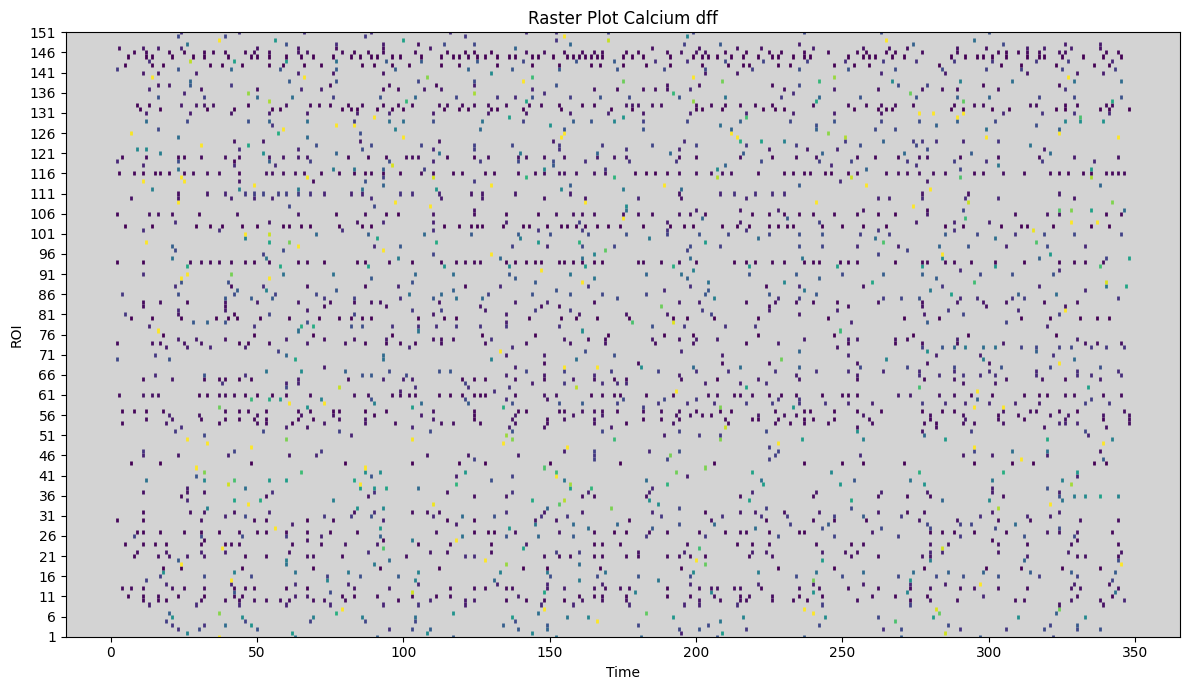

In [344]:
# plot the raster plot
fig, ax = plt.subplots(figsize=(12, 7))
for r in tqdm(range(1, rois + 1)):
    for p in store_data[r]["pks_dff"]:
        # Get the color for the current peak's dff value
        peak_intensity = store_data[r]["dff"][p]  # dff value at peak
        peak_color = cm.viridis(norm_dff_color(peak_intensity))  # Map to color
        ax.vlines(p, r - 0.5, r + 0.5, color=peak_color, lw=2)
ax.set_title("Raster Plot Calcium dff")
ax.set_xlabel("Time")
ax.set_ylabel("ROI")
# y axis only integers: 1, 2, 3, ...
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# start y axis at 1
ax.set_ylim(1, rois)
# set y ticks every 3
ax.set_yticks(np.arrange(1, rois + 1, 5))
ax.set_facecolor("lightgray")
plt.tight_layout()
plt.show()

100%|██████████| 151/151 [00:07<00:00, 20.33it/s]


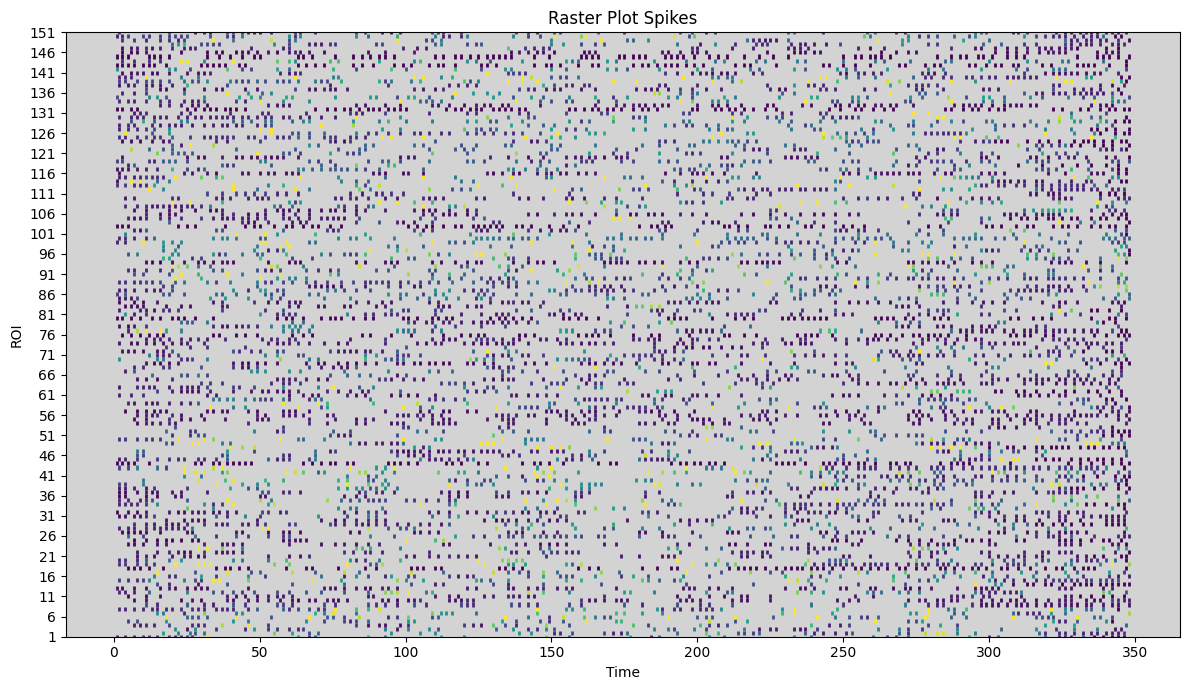

In [345]:
# plot the raster plot
fig, ax = plt.subplots(figsize=(12, 7))
for r in tqdm(range(1, rois + 1)):
    for p in store_data[r]["pks_spikes"]:
        # Get the color for the current peak's dff value
        spike_intensity = store_data[r]["pk"][p]  # pk value at peak
        spike_color = cm.viridis(norm_pk_color(spike_intensity))  # Map to color
        ax.vlines(p, r - 0.5, r + 0.5, color=spike_color, lw=2)
ax.set_title("Raster Plot Spikes")
ax.set_xlabel("Time")
ax.set_ylabel("ROI")
# y axis only integers: 1, 2, 3, ...
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# start y axis at 1
ax.set_ylim(1, rois)
# set y ticks every 3
ax.set_yticks(np.arrange(1, rois + 1, 5))
# set background color to light gray
ax.set_facecolor("lightgray")
plt.tight_layout()
plt.show()